# Structure Relations


## Setup

### Imports

In [1]:
# Type imports
from typing import Any, Dict, Tuple

# Standard Libraries
from pathlib import Path
from itertools import combinations
from math import sqrt, pi
import re
from statistics import mean
from pprint import pprint

# Shared Packages
import numpy as np
import pandas as pd
import xlwings as xw
import PySimpleGUI as sg
import pydicom
from shapely.geometry import Polygon
from shapely import points
import shapely

import RS_DICOM_Utilities


### Global Settings

In [2]:
PRECISION = 3


### Utility Functions

In [3]:
# Load Table
def load_table(file_name: Path, sheet_name: str, options: Dict[str, Any])->Any:
    '''Get a data collection from a spreadsheet.

    Returns the data found starting in the upper left cell of the spreadsheet.

    Args:
        file_name (Path): Path to the workbook.
        sheet_name (str): Name of the sheet in the workbook
        options (Dict[str, Any]): Converter options for teh data.

    Returns:
        Any: The data from the spreadsheet in the format dictated by the
            options.
    '''
    with xw.App() as app:
        book = app.books.open(file_name)

        range1 = book.sheets[sheet_name].range('A1').expand()
        data = range1.options(**options).value
    return data

## File Paths

In [4]:
base_path = Path.cwd()
data_path = base_path / 'Test Data'
dicom_path = data_path / 'StructureVolumeTests' / 'GJS_Struct_Tests'

Test Data\StructureVolumeTests\GJS_Struct_Tests\RS.GJS_Struct_Tests.SkippedSlices_A.dcm
Test Data\StructureVolumeTests\GJS_Struct_Tests\RS.GJS_Struct_Tests.SkippedSlices_B.dcm
Test Data\StructureVolumeTests\GJS_Struct_Tests\RS.GJS_Struct_Tests.SkippedSlices_C.dcm



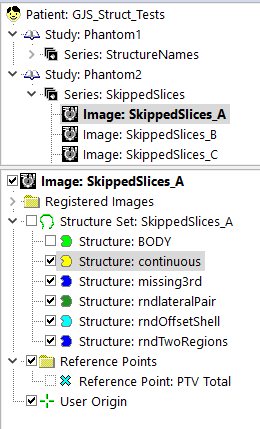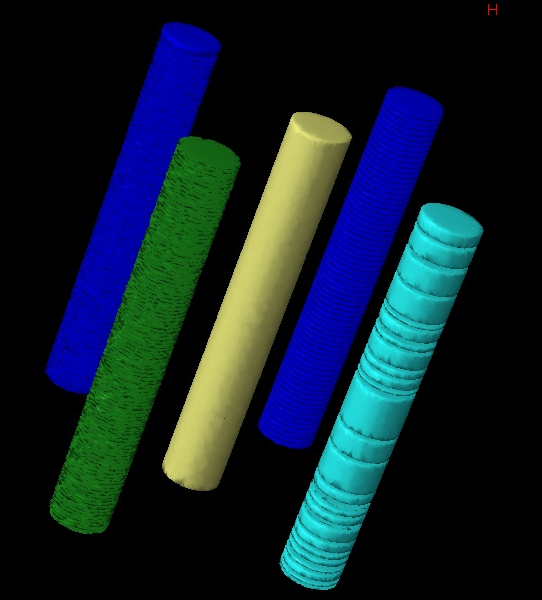

| StructureID    	| ROI # 	| DicomType 	| Volume 	| Equiv. Sphere Diam. 	|
|----------------	|-------	|-----------	|--------	|---------------------	|
| BODY           	| 1     	| EXTERNAL  	| 8043   	| 24.9                	|
| continuous     	| 2     	| NONE      	| 140.7  	| 6.5                 	|
| missing3rd     	| 5     	| NONE      	| 76.1   	| 5.3                 	|
| rndOffsetShell 	| 6     	| NONE      	| 111.7  	| 6                   	|
| rndTwoRegions  	| 4     	| NONE      	| 31.4   	| 3.9                 	|
| rndlateralPair 	| 3     	| NONE      	| 43.7   	| 4.4                 	|

***Volume A***
- Structure with continuous contours
- Structure with every other slice contoured
- Structure with every third slice contoured
- Structure with every third slice missing
- Structure with random missing slices.

- Do structures with missing slices need to be interpolated before analysis? 
  - If both structures have missing slices, intersections might be missed
- How to tell the difference between structures with missing slices and multi-region structures
  1. distance between slices with contours
  2. Multiple Gaps
  3. intersection between projection of contour from previous slice onto contour in current slice

- @2.5 mm / slice every cm = every 4 slices

In [5]:
skipped_slices_a = dicom_path / 'RS.GJS_Struct_Tests.SkippedSlices_A.dcm'

In [6]:
structure_set_info = RS_DICOM_Utilities.get_structure_file_info(skipped_slices_a)
structure_set_info

{'PatientName': 'StructureVolumes^Test',
 'PatientLastName': 'StructureVolumes',
 'PatientID': 'GJS_Struct_Tests',
 'StructureSet': 'SkippedSlices_A',
 'StudyID': 'Phantom2',
 'SeriesNumber': '0',
 'File': WindowsPath("d:/OneDrive - Queen's University/Python/Projects/StructureRelations/Test Data/StructureVolumeTests/GJS_Struct_Tests/RS.GJS_Struct_Tests.SkippedSlices_A.dcm")}

In [50]:
dataset = pydicom.dcmread(structure_set_info['File'])
name_lookup = RS_DICOM_Utilities.get_names_nums(dataset)

contour_sets = RS_DICOM_Utilities.read_contours(dataset)
contour_stats = pd.DataFrame(cntr.info for cntr in contour_sets.values())
contour_stats

,ROI Num,StructureID,Sup Slice,Inf Slice,Length,Thickness,Volume,Eq Sp Diam,Center of Mass,Resolution,Colour
0,1,BODY,10.0,-10.0,20.0,0.100,8019.694,24.834,"(0.0, 0.0, -0.0)",Normal,"(0, 255, 0)"
1,2,continuous,9.9,-9.9,19.8,0.099,140.613,6.452,"(0.015, -0.07, -0.005)",Normal,"(255, 255, 0)"
2,3,rndlateralPair,9.9,-9.9,19.8,0.198,141.577,6.466,"(-5.907, -6.427, 0.003)",Normal,"(30, 150, 30)"
3,4,rndTwoRegions,9.9,-9.9,19.8,0.287,142.157,6.476,"(-5.978, 6.585, 0.279)",Normal,"(0, 0, 255)"
4,5,missing3rd,9.9,-9.9,19.8,0.149,140.693,6.452,"(5.599, 6.445, -0.031)",Normal,"(0, 0, 255)"
5,6,rndOffsetShell,9.9,-9.9,19.8,0.118,140.913,6.456,"(5.659, -6.466, 0.286)",Normal,"(0, 255, 255)"


#### Build matrix of structures and the slices with contours

In [139]:
def build_slice_table(contour_sets)->pd.DataFrame:
    def slice_spacing(contour):
        inf = contour.dropna().index.min()
        sup = contour.dropna().index.max()
        contour_range = (contour.index <= sup) & (contour.index >= inf)
        slices = contour.loc[contour_range].dropna().index.to_series()
        gaps = slices.shift(-1) - slices
        return gaps

    def form_table(slice_index):
        slice_index.reset_index(inplace=True)
        slice_index.sort_values('Slice', inplace=True)
        slice_index.set_index(['Slice','StructureID'], inplace=True)
        slice_table = slice_index.unstack()
        slice_table.columns = slice_table.columns.droplevel()
        return slice_table

    slice_index = RS_DICOM_Utilities.build_contour_index(contour_sets)
    slice_table = form_table(slice_index)
    contour_slices = slice_table.apply(slice_spacing)
    return contour_slices

In [140]:
contour_slices = build_slice_table(contour_sets)
contour_slices

StructureID,BODY,continuous,missing3rd,rndOffsetShell,rndTwoRegions,rndlateralPair
Slice,,,,,,
-10.0,0.1,NaN,NaN,NaN,NaN,NaN
-9.9,0.1,0.1,0.1,0.2,0.3,0.2
-9.8,0.1,0.1,0.2,NaN,NaN,NaN
-9.7,0.1,0.1,NaN,0.1,NaN,0.2
-9.6,0.1,0.1,0.1,0.2,0.3,NaN
...,...,...,...,...,...,...
9.6,0.1,0.1,0.1,0.1,0.1,NaN
9.7,0.1,0.1,0.2,0.1,0.1,0.2
9.8,0.1,0.1,NaN,0.1,0.1,NaN


#### Identify contours with gaps

In [147]:
def has_gaps(structure_id, contour_slices) -> bool:
    inf = contour_slices[structure_id].dropna().index.min()
    sup = contour_slices[structure_id].dropna().index.max()

    contour_range = (contour_slices.index <= sup) & (contour_slices.index >= inf)
    missing_slices = contour_slices.loc[contour_range, structure_id].isna()
    return any(missing_slices)

In [148]:
has_gaps('missing3rd', contour_slices)

True

In [149]:
has_gaps('continuous', contour_slices)

False

#### Find distance between slices with contours

In [150]:
contour_slices

StructureID,BODY,continuous,missing3rd,rndOffsetShell,rndTwoRegions,rndlateralPair
Slice,,,,,,
-10.0,0.1,NaN,NaN,NaN,NaN,NaN
-9.9,0.1,0.1,0.1,0.2,0.3,0.2
-9.8,0.1,0.1,0.2,NaN,NaN,NaN
-9.7,0.1,0.1,NaN,0.1,NaN,0.2
-9.6,0.1,0.1,0.1,0.2,0.3,NaN
...,...,...,...,...,...,...
9.6,0.1,0.1,0.1,0.1,0.1,NaN
9.7,0.1,0.1,0.2,0.1,0.1,0.2
9.8,0.1,0.1,NaN,0.1,0.1,NaN


In [171]:
slices = contour_slices.index.to_series()
spacing = slices.shift(-1) - slices
spacing.describe()

count    2.000000e+02
mean     1.000000e-01
std      4.304374e-16
min      1.000000e-01
25%      1.000000e-01
50%      1.000000e-01
75%      1.000000e-01
max      1.000000e-01
Name: Slice, dtype: float64

In [161]:
structure_id = 'missing3rd'

inf = contour_slices[structure_id].dropna().index.min()
sup = contour_slices[structure_id].dropna().index.max()

contour_range = (contour_slices.index <= sup) & (contour_slices.index >= inf)
structure_slices = contour_slices.loc[contour_range, structure_id]
missing_slices = structure_slices.isna()

structure_slices[missing_slices.shift(-1, fill_value=True)]

Slice
-9.8    0.2
-9.5    0.2
-9.2    0.2
-8.9    0.2
-8.6    0.2
       ... 
 8.5    0.2
 8.8    0.2
 9.1    0.2
 9.4    0.2
 9.7    0.2
Name: missing3rd, Length: 66, dtype: float64

In [170]:
structure_id = 'rndOffsetShell'

inf = contour_slices[structure_id].dropna().index.min()
sup = contour_slices[structure_id].dropna().index.max()

contour_range = (contour_slices.index <= sup) & (contour_slices.index >= inf)
structure_slices = contour_slices.loc[contour_range, structure_id]
missing_slices = structure_slices.isna()

structure_slices[missing_slices.shift(-1, fill_value=True)]

Slice
-9.9    0.2
-9.6    0.2
-9.1    0.2
-8.8    0.3
-8.7    NaN
-8.3    0.2
-7.9    0.2
-7.3    0.2
-6.5    0.2
-6.3    0.2
-5.8    0.2
-5.4    0.2
-5.2    0.3
-5.1    NaN
-4.5    0.2
-2.7    0.2
-1.4    0.2
 1.0    0.3
 1.1    NaN
 1.4    0.2
 2.0    0.2
 2.5    0.2
 3.5    0.2
 3.9    0.3
 4.0    NaN
 4.7    0.2
 5.0    0.2
 6.5    0.2
 7.9    0.3
 8.0    NaN
 9.1    0.2
 9.8    0.1
Name: rndOffsetShell, dtype: float64

In [163]:
roi_lookup = {cntr.structure_id: cntr.roi_num
              for cntr in contour_sets.values()}
roi_lookup

{'BODY': '1',
 'continuous': '2',
 'rndlateralPair': '3',
 'rndTwoRegions': '4',
 'missing3rd': '5',
 'rndOffsetShell': '6'}

In [162]:
roi = roi_lookup[structure_id]
roi

'5'

In [74]:
idx = contour_stats.index[contour_stats.StructureID == structure_id][0]
contour_stats.at[idx, 'Sup Slice']

# Done to Here


# Metrics

In [21]:
contour_sets[2].contours[0].contour.distance(contour_sets[3].contours[0].contour)

1.9694190053912657

In [22]:
contour_sets[3].contours[0].contour.distance(contour_sets[13].contours[0].contour)

0.47761072014769523

In [23]:
contour_sets[13].contours[0].contour.bounds

(1.7420000000000002, -3.174, 2.741, -2.175)

In [24]:
contour_sets[3].contours[0].contour.bounds

(0.728, -4.176, 3.726, -1.176)

`bounds(geometry, **kwargs)`
Computes the bounds (extent) of a geometry.

For each geometry these 4 numbers are returned: 
> (min x, min y, max x, max y)

In [25]:
contour_sets[2].contours[0].contour.bounds

(-4.235, -4.446, -1.2349999999999999, -1.4460000000000002)

In [26]:
contour = contour_sets[2].contours[0].contour.bounds

In [27]:
slices = contour_sets[3].contours[0].contour.bounds


In [28]:
[(contour[0], contour[1]), (contour[2], contour[3]), (contour[0], contour[3]), (contour[2], contour[1])]

[(-4.235, -4.446),
 (-1.2349999999999999, -1.4460000000000002),
 (-4.235, -1.4460000000000002),
 (-1.2349999999999999, -4.446)]